# I model a brain circuit based off of the Izhikevich model -- http://www.izhikevich.org/publications/spikes.htm

In [ ]:
# import all necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Simulating one brain cell

In [ ]:
# Defining the parameters for one brain cell
a  = .02
b  = .2
c  = -50
d  = 2

v = -65      
u = b*v      

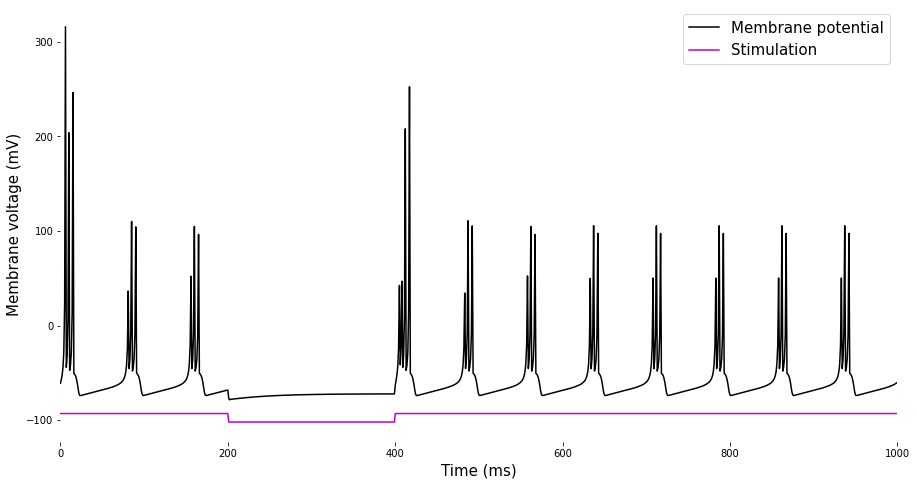

In [ ]:


# I am defining the variables
simulation_time = 1000
memvolt = np.zeros(simulation_time)
Iall = np.zeros(simulation_time)


# I amlooping through simulation time
for t in range(simulation_time):

  # First, defining the exogenous input strength
  I = -2 if (t>200) & (t<400) else 7

  
  # Second, checking if there is an action potential and update
  if v >= 30:
    v = c
    u += d
  
  # Finally, updating the membrane voltage
  v += .04*v**2 + 5*v + 140 - u + I
  u += a*(b*v-u)
  
  # And collecting the variables for plotting
  memvolt[t] = v
  Iall[t] = I


fig,ax = plt.subplots(1,figsize=(15,8))
plt.plot(memvolt,'k',label='Membrane potential')
plt.plot(Iall-100,'m',label='Stimulation')
plt.xlabel('Time (ms)',fontsize=15)
plt.ylabel('Membrane voltage (mV)',fontsize=15)
plt.box(False)
plt.xlim([0,simulation_time])
plt.legend(fontsize=15)
plt.show()

# Creating a circuit of 1000 neurons

In [ ]:
# Here I define how many of each neuron there is and their specific characteristics. 

# Excitatory neurons                 Inhibitory neurons
Ne = 800;                            Ni = 200
re = np.random.rand(Ne);             ri = np.random.rand(Ni)

#               excitatory           inhibitory
a = np.hstack((.02*np.ones(Ne),     .02+.08*ri))
b = np.hstack((.2*np.ones(Ne),      .25-.05*ri))
c = np.hstack((-65+15*re**2,        -65*np.ones(Ni)))
d = np.hstack((8-6*re**2,            2*np.ones(Ni)))

# initial values of v and u
v = -65*np.ones(Ne+Ni)
u = b*v

# matrix of all-to-all synaptic weights
S = np.hstack((.5*np.random.rand(Ne+Ni,Ne), -np.random.rand(Ne+Ni,Ni) ))

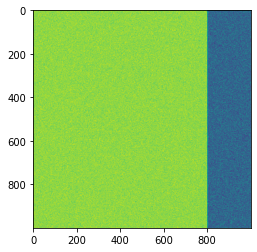

In [ ]:
plt.imshow(S);

# Simulate the neural circuit

In [ ]:
# initializations of our variables
simulation_time = 5000
firings = np.array([[],[]])

# looping through simulation time
for t in range(simulation_time):

  # defining the random exogenous input strength (different for E and I cells)
  I = np.hstack((5*np.random.randn(Ne),2*np.random.randn(Ni)))
  # I = np.hstack((5*np.ones(Ne),2*np.ones(Ni)))
  
  # checking if there is an action potential and updating the firings array to store which neurons fired
  fired   = np.where(v>=30)[0]
  tmp     = np.stack((np.tile(t,len(fired)),fired))
  firings = np.concatenate((firings,tmp),axis=1)

  # updating the membrane variables for the cells that fired
  v[fired] = c[fired]
  u[fired] = u[fired] + d[fired]

  # updating the membrane variables for down-stream cells
  I += np.sum(S[:,fired],axis=1)
  
  # updating membrane voltage
  v += .04*v**2 + 5*v + 140 - u + I
  u += a*(b*v-u)


In [ ]:
print(firings.shape)
firings

(2, 41458)


array([[   5.,    7.,    7., ..., 4999., 4999., 4999.],
       [ 379.,  269.,  325., ...,  212.,  500.,  755.]])

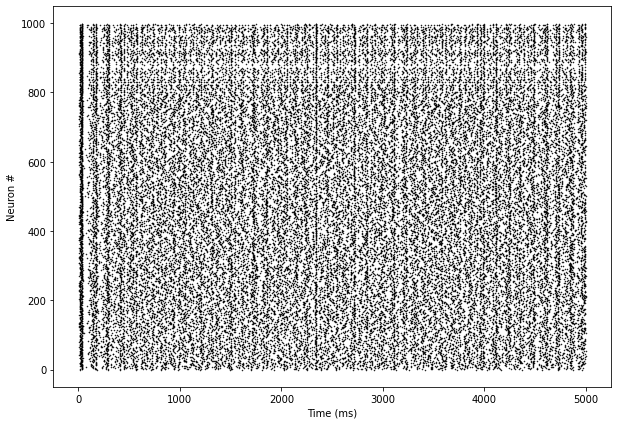

In [ ]:
# visualizing all the firings
fig,ax = plt.subplots(1,figsize=(10,7))

plt.plot(firings[0,:],firings[1,:],'k.',markersize=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron #')
# plt.xlim([1000,2000])
plt.show()

# Visualizing the population activity


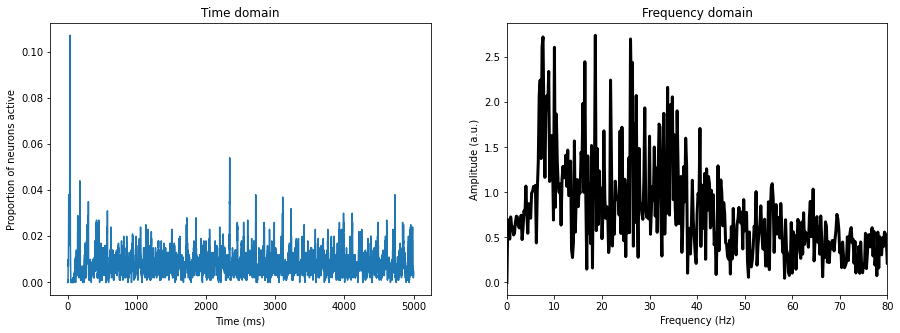

In [ ]:
# population spiking activity
popact = np.zeros(simulation_time)

# looping over time and finding the units that spiked at that time
for ti in range(simulation_time):
  popact[ti] = np.sum(firings[0,:]==ti) / (Ne+Ni)


fig,ax = plt.subplots(1,2,figsize=(15,5))

# time-domain plot
ax[0].plot(popact)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Proportion of neurons active')
ax[0].set_title('Time domain')
# ax[0].set_xlim([1000,1500])
# ax[0].set_ylim([0,.1])


# frequency-domain plot
popactX = np.abs(np.fft.fft(popact-np.mean(popact)))
hz = np.linspace(0,500,int(simulation_time/2+1))

ax[1].plot(hz,popactX[:len(hz)],'k',linewidth=3)
ax[1].set_xlim([0,80])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude (a.u.)')
ax[1].set_title('Frequency domain')

plt.show()

# Running some experiments!




In [ ]:
# Defining a function to run the network

def simCircuit(I):
    
  simulation_time = 5000
  firings = np.array([[],[]])
  v = -65*np.ones(Ne+Ni)
  u = b*v

  # looping through simulation time
  for t in range(len(I)):

  # defining random exogenous input strength (different for E and I cells)
    stim = np.hstack((4*np.random.randn(Ne),1*np.random.randn(Ni)))
    stim = stim + I[t]
  # I = np.hstack((5*np.ones(Ne),2*np.ones(Ni)))
  
  # checking if there is an action potential and updating
    fired   = np.where(v>=30)[0]
    tmp     = np.stack((np.tile(t,len(fired)),fired))
    firings = np.concatenate((firings,tmp),axis=1)

  # updating the membrane variables for cells that fired
    v[fired] = c[fired]
    u[fired] = u[fired] + d[fired]

  # updating the membrane variables for down-stream cells
    stim += np.sum(S[:,fired],axis=1)
  
  # updating the membrane voltage
    v += .04*v**2 + 5*v + 140 - u + stim
    u += a*(b*v-u)

  return firings

In [ ]:
def plotPopActivity(firings):

  npnts = int(np.max(firings[0,:])+1)

    # population spiking activity
  popact = np.zeros(npnts)

  # looping over time and finding the units that spiked at that time
  for ti in range(npnts):
    popact[ti] = np.sum(firings[0,:]==ti) / (Ne+Ni)

  # Creating a frequency-domain plot
  popactX = np.abs(np.fft.fft(popact-np.mean(popact)))
  hz = np.linspace(0,500,int(npnts/2+1))

  
  # Creating a spiking activity plot
  fig,ax = plt.subplots(1,3,figsize=(15,5))

  ax[0].plot(firings[0,:],firings[1,:],'k.',markersize=1)
  ax[0].plot(I*50+100, 'm', linewidth = 2)
  ax[0].set_title('All neurons firing')
  ax[0].set_xlabel('Time (ms)')
  ax[0].set_ylabel('Neuron')

  # time-domain plot
  ax[1].plot(popact)
  ax[1].set_xlabel('Time (ms)')
  ax[1].set_ylabel('Proportion of neurons active')
  ax[1].set_title('Time domain')


  # frequency-domain plot

  ax[2].plot(hz,popactX[:len(hz)],'k',linewidth=3)
  ax[2].set_xlim([0,60])
  ax[2].set_xlabel('Frequency (Hz)')
  ax[2].set_ylabel('Amplitude (a.u.)')
  ax[2].set_title('Frequency domain')


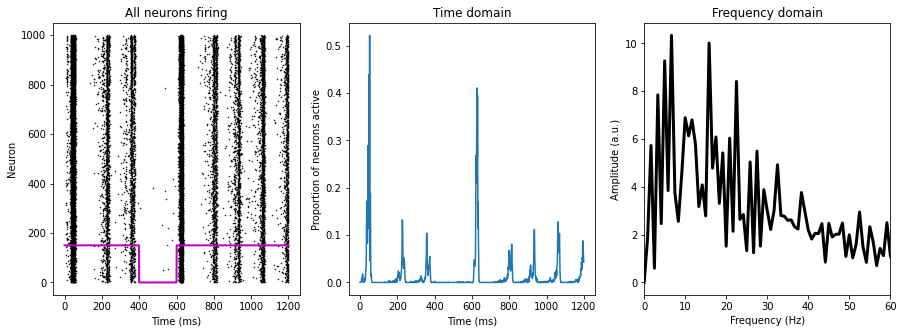

In [ ]:
#Experiment 1
I = np.ones(1200) # Define exogenous input
I[400:601] = -2

# running the simulation and visualizing the results

networkcircuits = simCircuit(I)
plotPopActivity(networkcircuits)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in add


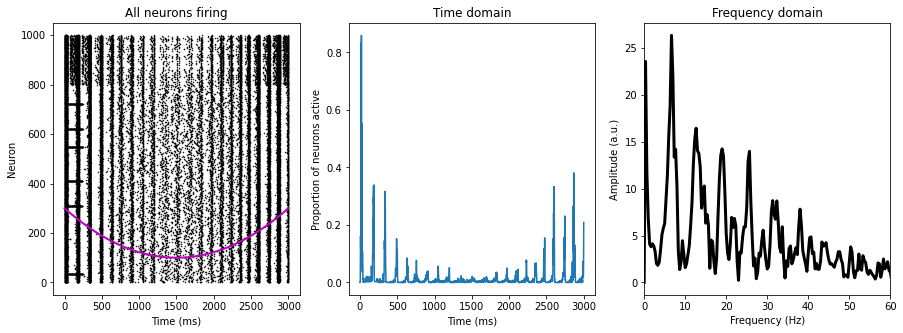

In [ ]:
# Experiment 2 

I = np.linspace(-2,2,3000)**2 # Defining the exogenous input

# running the simulation and visualizing the results

networkcircuits = simCircuit(I)
plotPopActivity(networkcircuits)

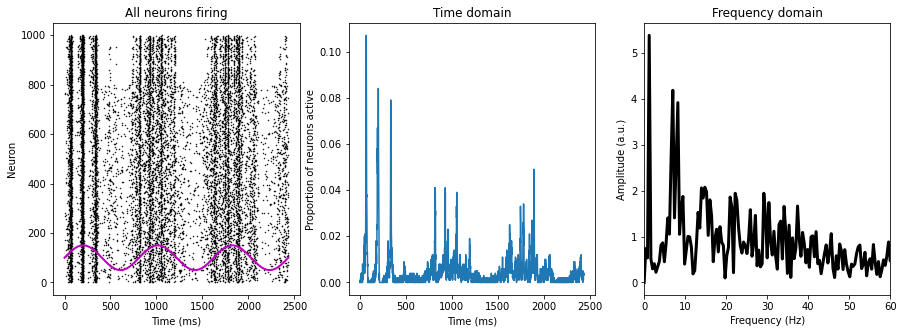

In [ ]:
# Experiment 3

I = np.sin(np.linspace(0,6*np.pi,2435)) # Defining the exogenous input

# running the simulation and visualizing the results
networkspikes = simCircuit(I)
plotPopActivity(networkspikes)